In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV3
from torch_geometric.data import DataLoader 
from imports.models import Net_DE, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
import pandas as pd

df_GAT = pd.read_csv("csvMix/df_GAT_Mix_017.csv")
df_DEC = pd.read_csv("csvMix/df_DE_mix_0175.csv")
df_Trans = pd.read_csv("csvMix/df_Trans_Mix_016.csv")
df_Track = pd.read_csv("csvMix/df_TICL_track.csv")
df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")


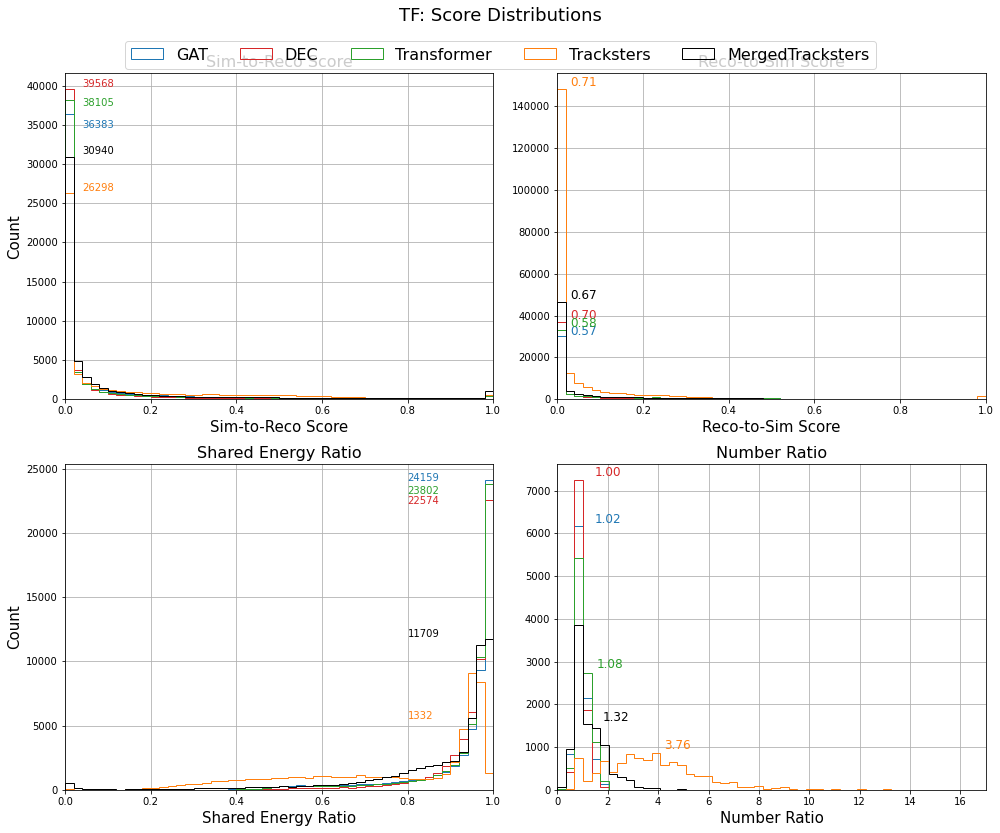

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Data Organization & Common Settings
# -------------------------------
dfs = {
    "GAT":              df_GAT,
    "DEC":              df_DEC,          # renamed key
    "Transformer":      df_Trans,
    "Tracksters":       df_Track,
    "MergedTracksters": df_MT,
}

colors = {
    "GAT":              "tab:blue",
    "DEC":              "tab:red",   # renamed key
    "Transformer":      "tab:green",
    "Tracksters":       "tab:orange",
    "MergedTracksters": "black",
}

bins_sim = np.linspace(0, 1, 51)

# -------------------------------
# 2. Sim-to-Reco Score
# -------------------------------
sim_to_reco_data = {}
for key, df in dfs.items():
    cols = {"event_index", "cp_id", "sim_to_reco_score"}
    if cols.issubset(df.columns):
        idx = df.groupby(["event_index", "cp_id"])["sim_to_reco_score"] \
                .apply(lambda x: x.abs().idxmin())
        sim_to_reco_data[key] = df.loc[idx, "sim_to_reco_score"].values
    else:
        print(f"Missing {cols} in {key}")

offsets_sim = {
    "GAT":              -2000,
    "DEC":              0,   # renamed key
    "Transformer":      -1000,
    "Tracksters":       15,
    "MergedTracksters": 30,
}
sim_x_offset = 0.03

# -------------------------------
# 3. Reco-to-Sim Score
# -------------------------------
reco_to_sim_data = {}
for key, df in dfs.items():
    cols = {"event_index", "trackster_id", "reco_to_sim_score"}
    if cols.issubset(df.columns):
        idx = df.groupby(["event_index", "trackster_id"])["reco_to_sim_score"] \
                .apply(lambda x: x.abs().idxmin())
        reco_to_sim_data[key] = df.loc[idx, "reco_to_sim_score"].values
    else:
        print(f"Missing {cols} in {key}")

offsets_reco = {
    "GAT":              -1000,
    "DEC":              0,      # renamed key
    "Transformer":      0,
    "Tracksters":       20,
    "MergedTracksters": 30,
}
reco_x_offset = 0.02

# -------------------------------
# 4. Shared Energy Ratio
# -------------------------------
shared_energy_data = {}
for key, df in dfs.items():
    cols = {"event_index", "cp_id", "shared_energy", "cp_raw_energy"}
    if cols.issubset(df.columns):
        tmp = df.copy()
        tmp["energy_ratio"] = tmp["shared_energy"] / tmp["cp_raw_energy"]
        shared_energy_data[key] = tmp.groupby(["event_index", "cp_id"])["energy_ratio"].max().values
    else:
        print(f"Missing {cols} in {key}")

global_max_e = max(np.max(v) for v in shared_energy_data.values() if len(v)>0)
upper_bound_energy = max(1, global_max_e)
bins_shared = np.linspace(0, upper_bound_energy, 51)

energy_offsets = {
    "GAT":              -250,
    "DEC":              -500,    # renamed key
    "Transformer":      -900,
    "Tracksters":       4000,
    "MergedTracksters": 10,
}
energy_x_offsets = {
    "GAT":              0.3,
    "DEC":              0.3,   # renamed key
    "Transformer":      0.3,
    "Tracksters":       0.3,
    "MergedTracksters": 0.3,
}

# -------------------------------
# 5. Number Ratio (#tracks / #cps)
# -------------------------------
ratio_data = {}
for key, df in dfs.items():
    cols = {"event_index", "cp_id", "trackster_id"}
    if cols.issubset(df.columns):
        ratios = df.groupby("event_index").apply(
            lambda sub: sub["trackster_id"].nunique() / sub["cp_id"].nunique()
            if sub["cp_id"].nunique()>0 else np.nan
        ).dropna()
        ratio_data[key] = ratios.values
    else:
        print(f"Missing {cols} in {key}")

global_max_r = max(np.max(v) for v in ratio_data.values() if len(v)>0)
upper_bound_ratio = max(1, global_max_r)
bins_ratio = np.linspace(0, upper_bound_ratio, 51)

ratio_mean_offsets = {
    "GAT":              0,
    "DEC":              10,     # renamed key
    "Transformer":      40,
    "Tracksters":       30,
    "MergedTracksters": 10,
}
ratio_x_offsets = {k: 1 for k in dfs.keys()}

# -------------------------------
# 6. Annotation Helpers (unchanged)
# -------------------------------
def annotate_hist(ax, scores, bins_used, target_value, x_offset=0.0, y_offset=0.0, font_size=10, color="black"):
    counts, bins_local = np.histogram(scores, bins=bins_used)
    if target_value == 0:
        idx = 0
    elif target_value >= bins_used[-2]:
        idx = -1
    else:
        idx = np.searchsorted(bins_local, target_value) - 1
    x = (bins_local[idx] + bins_local[idx+1]) / 2 + x_offset
    y = counts[idx] + y_offset
    ax.text(x, y, str(counts[idx]), fontsize=font_size, ha='left', va='bottom', color=color)

def annotate_fraction(ax, scores, bins_used, target_value=0, x_offset=0.0, y_offset=0.0, font_size=12, color="black"):
    counts, bins_local = np.histogram(scores, bins=bins_used)
    total = counts.sum()
    if total>0:
        if target_value == 0:
            idx = 0
        elif target_value >= bins_used[-2]:
            idx = -1
        else:
            idx = np.searchsorted(bins_local, target_value) - 1
        frac = counts[idx]/total
    else:
        idx, frac = 0, 0
    x = (bins_local[idx] + bins_local[idx+1]) / 2 + x_offset
    y = counts[idx] + y_offset
    ax.text(x, y, f"{frac:.2f}", fontsize=font_size, ha='left', va='bottom', color=color)

def annotate_mean(ax, scores, bins_used, x_offset=0.0, y_offset=0.0, font_size=12, color="black"):
    mean_val = np.mean(scores)
    counts, bins_local = np.histogram(scores, bins=bins_used)
    idx = np.searchsorted(bins_local, mean_val) - 1
    idx = max(idx, 0)
    y = counts[idx]
    ax.text(mean_val + x_offset, y + y_offset, f"{mean_val:.2f}",
            fontsize=font_size, ha='center', va='bottom', color=color)

# -------------------------------
# 7. Plotting in a 2×2 Grid
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top‑Left: Sim‑to‑Reco
axes[0,0].set_title("Sim-to-Reco Score", fontsize=16)
for key, scores in sim_to_reco_data.items():
    axes[0,0].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_hist(axes[0,0], scores, bins_sim, 0,
                  x_offset=sim_x_offset, y_offset=offsets_sim[key], color=colors[key])
axes[0,0].set_xlim(0,1)
axes[0,0].set_xlabel("Sim-to-Reco Score", fontsize=15)
axes[0,0].set_ylabel("Count", fontsize=15)
axes[0,0].grid(True)

# Top‑Right: Reco‑to‑Sim
axes[0,1].set_title("Reco-to-Sim Score", fontsize=16)
for key, scores in reco_to_sim_data.items():
    axes[0,1].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_fraction(axes[0,1], scores, bins_sim, 0,
                      x_offset=reco_x_offset, y_offset=offsets_reco[key], color=colors[key])
axes[0,1].set_xlim(0,1)
axes[0,1].set_xlabel("Reco-to-Sim Score", fontsize=15)
axes[0,1].set_ylabel("", fontsize=15)
axes[0,1].grid(True)

# Bottom‑Left: Shared Energy Ratio
axes[1,0].set_title("Shared Energy Ratio", fontsize=16)
for key, scores in shared_energy_data.items():
    axes[1,0].hist(scores, bins=bins_shared, histtype='step', color=colors[key], label=key)
    annotate_hist(axes[1,0], scores, bins_shared, 1,
                  x_offset=energy_x_offsets[key], y_offset=energy_offsets[key], color=colors[key])
axes[1,0].set_xlim(0,upper_bound_energy)
axes[1,0].set_xlabel("Shared Energy Ratio", fontsize=15)
axes[1,0].set_ylabel("Count", fontsize=15)
axes[1,0].grid(True)

# Bottom‑Right: Number Ratio
axes[1,1].set_title("Number Ratio", fontsize=16)
for key, scores in ratio_data.items():
    axes[1,1].hist(scores, bins=bins_ratio, histtype='step', color=colors[key], label=key)
    annotate_mean(axes[1,1], scores, bins_ratio,
                  x_offset=ratio_x_offsets[key], y_offset=ratio_mean_offsets[key], color=colors[key])
axes[1,1].set_xlim(0,upper_bound_ratio)
axes[1,1].set_xlabel("Number Ratio", fontsize=15)
axes[1,1].set_ylabel("", fontsize=15)
axes[1,1].grid(True)

# Add overall title
fig.suptitle("TF: Score Distributions", fontsize=18, y=0.96)

# Common legend just below the suptitle
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.93),
           ncol=len(labels), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

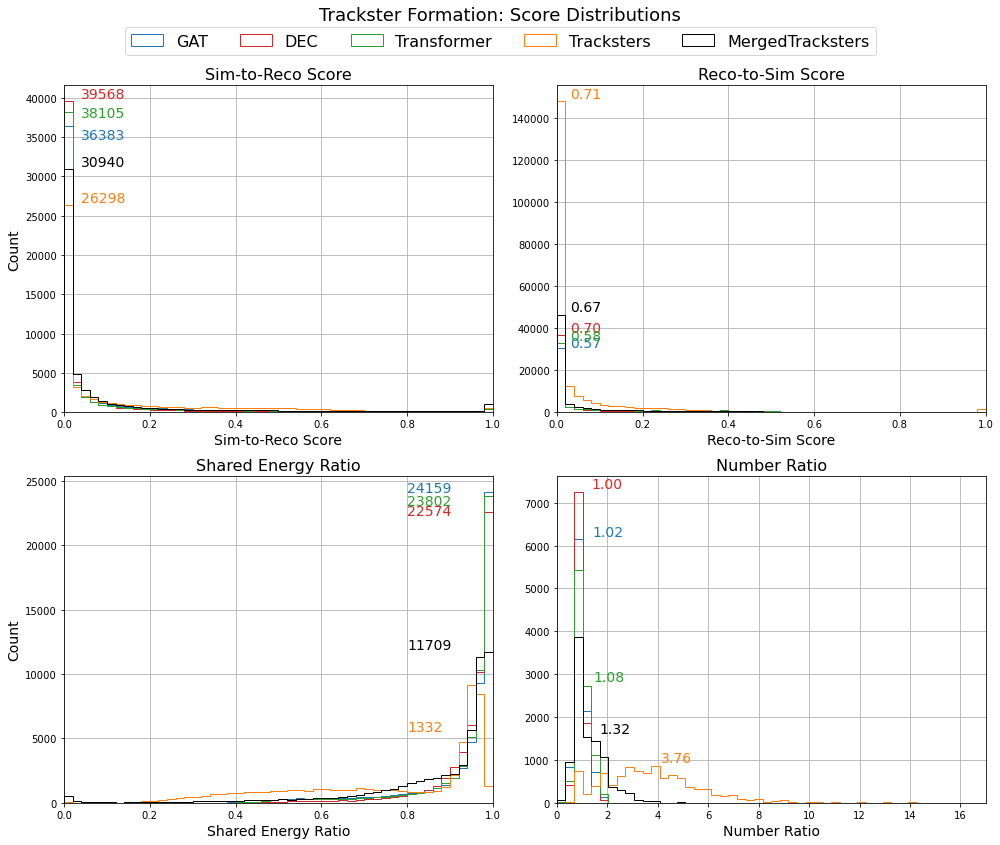

In [7]:
# 7. Plotting in a 2×2 Grid
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top‑Left: Sim‑to‑Reco
axes[0,0].set_title("Sim-to-Reco Score", fontsize=16)
for key, scores in sim_to_reco_data.items():
    axes[0,0].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_hist(
        axes[0,0], scores, bins_sim, 0,
        x_offset=sim_x_offset, y_offset=offsets_sim[key],
        font_size=14, color=colors[key]
    )
axes[0,0].set_xlim(0,1)
axes[0,0].set_xlabel("Sim-to-Reco Score", fontsize=14)
axes[0,0].set_ylabel("Count", fontsize=14)
axes[0,0].grid(True)

# Top‑Right: Reco‑to‑Sim
axes[0,1].set_title("Reco-to-Sim Score", fontsize=16)
for key, scores in reco_to_sim_data.items():
    axes[0,1].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_fraction(
        axes[0,1], scores, bins_sim, 0,
        x_offset=reco_x_offset, y_offset=offsets_reco[key],
        font_size=14, color=colors[key]
    )
axes[0,1].set_xlim(0,1)
axes[0,1].set_xlabel("Reco-to-Sim Score", fontsize=14)
axes[0,1].set_ylabel("", fontsize=16)
axes[0,1].grid(True)

# Bottom‑Left: Shared Energy Ratio
axes[1,0].set_title("Shared Energy Ratio", fontsize=16)
for key, scores in shared_energy_data.items():
    axes[1,0].hist(scores, bins=bins_shared, histtype='step', color=colors[key], label=key)
    annotate_hist(
        axes[1,0], scores, bins_shared, 1,
        x_offset=energy_x_offsets[key], y_offset=energy_offsets[key],
        font_size=14, color=colors[key]
    )
axes[1,0].set_xlim(0,upper_bound_energy)
axes[1,0].set_xlabel("Shared Energy Ratio", fontsize=14)
axes[1,0].set_ylabel("Count", fontsize=14)
axes[1,0].grid(True)

# Bottom‑Right: Number Ratio
axes[1,1].set_title("Number Ratio", fontsize=16)
for key, scores in ratio_data.items():
    axes[1,1].hist(scores, bins=bins_ratio, histtype='step', color=colors[key], label=key)
    annotate_mean(
        axes[1,1], scores, bins_ratio,
        x_offset=ratio_x_offsets[key], y_offset=ratio_mean_offsets[key],
        font_size=14, color=colors[key]
    )
axes[1,1].set_xlim(0,upper_bound_ratio)
axes[1,1].set_xlabel("Number Ratio", fontsize=14)
axes[1,1].set_ylabel("", fontsize=14)
axes[1,1].grid(True)

# Add overall title
fig.suptitle("Trackster Formation: Score Distributions", fontsize=18, y=0.975)

# Common legend just below the suptitle
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96),
           ncol=len(labels), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("TFscores.pdf")
plt.show()


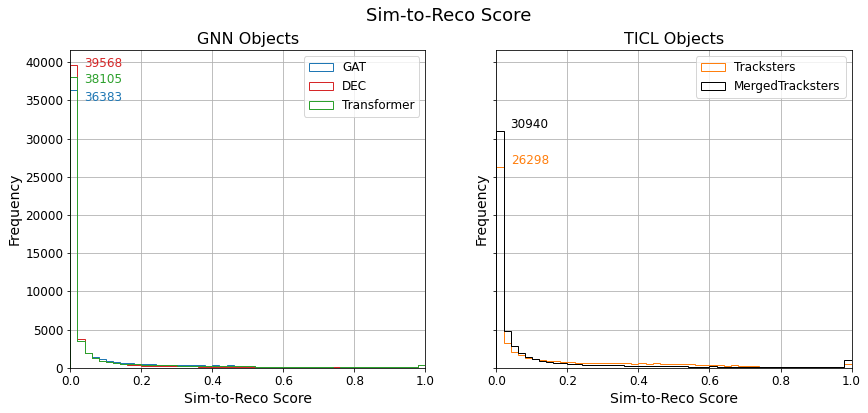

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assumption: these DataFrames are already loaded ---
# Example:
# df_GAT = pd.read_csv("csvMix/df_GAT_Mix_017.csv")
# df_DE = pd.read_csv("csvMix/df_DE_mix_0175.csv")
# df_Trans = pd.read_csv("csvMix/df_Trans_Mix_016.csv")
# df_Track = pd.read_csv("csvMix/df_TICL_track.csv")
# df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

# Organize dataframes into a dictionary using consistent keys.
dfs = {
    "GAT": df_GAT,
    "DEC": df_DE,
    "Transformer": df_Trans,
    "Tracksters": df_Track,
    "MergedTracksters": df_MT,
}

# Define groups for plotting.
# "GNN Objects" (left) will come from: GAT, DEC, Transformer.
# "TICL Objects" (right) will come from: Tracksters, MergedTracksters.
left_group = ["GAT", "DEC", "Transformer"]
right_group = ["Tracksters", "MergedTracksters"]

# Set fixed bins (0 to 1 with 50 bins) and assign colours.
bins_fixed = np.linspace(0, 1, 51)
colors = {
    "GAT": "tab:blue",
    "DEC": "tab:red",             # DEC is now red.
    "Transformer": "tab:green",
    "Tracksters": "tab:orange",   # Tracksters now has a different colour.
    "MergedTracksters": "black" # MergedTracksters remains black.
}


# --- 1. Process sim_to_reco_score ---
sim_to_reco_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "sim_to_reco_score"}
    if required_cols.issubset(df.columns):
        # For each event and cp_id, select the row with sim_to_reco_score closest to 0.
        best_idx = df.groupby(["event_index", "cp_id"])["sim_to_reco_score"].apply(lambda x: x.abs().idxmin())
        best_scores = df.loc[best_idx, "sim_to_reco_score"]
        sim_to_reco_data[key] = best_scores.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# --- Annotation Helper (objective frequency) ---
def annotate_hist(ax, scores, target_value, x_offset=0.0, y_offset=0.0, font_size=14, color='k'):
    counts, bins = np.histogram(scores, bins=bins_fixed, density=False)
    # Determine the bin corresponding to target_value.
    if target_value == 0:
        bin_index = 0
        x_loc = (bins[0] + bins[1]) / 2
    elif target_value == 1:
        bin_index = -1
        x_loc = (bins[-2] + bins[-1]) / 2
    else:
        bin_index = np.searchsorted(bins, target_value) - 1
        x_loc = (bins[bin_index] + bins[bin_index+1]) / 2
    # Apply horizontal and vertical offsets.
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = str(counts[bin_index])
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

# --- Define individual offsets for each dataset (adjust these as needed) ---
left_offsets = {    # For GNN Objects
    "GAT": -1800,        
    "DEC": -600,       
    "Transformer": -1200  
}
right_offsets = {   # For TICL Objects
    "Tracksters": 0,         
    "MergedTracksters": 30   
}

# --- 2. Plot sim_to_reco_score ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Adjust the suptitle position using the y parameter.
plt.suptitle("Sim-to-Reco Score", fontsize=18, y=0.96)
axes[0].set_title("GNN Objects", fontsize=16)
axes[1].set_title("TICL Objects", fontsize=16)

# Plot left group.
for key in left_group:
    if key in sim_to_reco_data:
        scores = sim_to_reco_data[key]
        axes[0].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = left_offsets.get(key, 0)
        annotate_hist(axes[0], scores, target_value=0, x_offset=0.03, y_offset=offset, font_size=12, color=colors[key])

# Plot right group.
for key in right_group:
    if key in sim_to_reco_data:
        scores = sim_to_reco_data[key]
        axes[1].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = right_offsets.get(key, 0)
        annotate_hist(axes[1], scores, target_value=0, x_offset=0.03, y_offset=offset, font_size=12, color=colors[key])

for ax in axes:
    ax.set_xlabel("Sim-to-Reco Score", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(0, 1)
    ax.legend(fontsize=12)
    ax.grid(True)

# Adjust the top margin to reduce the gap between the suptitle and the subplots.
plt.subplots_adjust(top=0.86)  # adjust the top parameter as needed
plt.show()


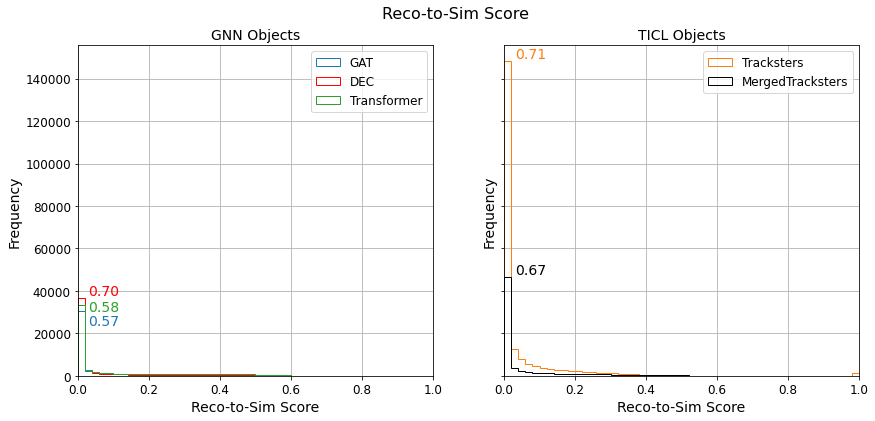

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assumption: these DataFrames are already loaded ---
# Example:
# df_GAT = pd.read_csv("csvMix/df_GAT_Mix_017.csv")
# df_DE = pd.read_csv("csvMix/df_DE_mix_0175.csv")
# df_Trans = pd.read_csv("csvMix/df_Trans_Mix_016.csv")
# df_Track = pd.read_csv("csvMix/df_TICL_track.csv")
# df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

dfs = {
    "GAT": df_GAT,
    "DEC": df_DE,
    "Transformer": df_Trans,
    "Tracksters": df_Track,
    "MergedTracksters": df_MT,
}

# Define groups (left: "GNN Objects", right: "TICL Objects")
left_group = ["GAT", "DEC", "Transformer"]
right_group = ["Tracksters", "MergedTracksters"]

# Fixed bins from 0 to 1 (50 bins) and updated color definitions.
bins_fixed = np.linspace(0, 1, 51)
colors = {
    "GAT": "tab:blue",
    "DEC": "red",               # DEC is now red.
    "Transformer": "tab:green",
    "Tracksters": "tab:orange", # Tracksters is now tab:orange.
    "MergedTracksters": "black"   # MergedTracksters is set to black.
}

# --- 1. Process reco_to_sim_score ---
# For each dataframe, group by event_index and trackster_id and pick the row with the reco_to_sim_score
# closest to zero.
reco_to_sim_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "trackster_id", "reco_to_sim_score"}
    if required_cols.issubset(df.columns):
        best_idx = df.groupby(["event_index", "trackster_id"])["reco_to_sim_score"]\
                     .apply(lambda x: x.abs().idxmin())
        best_scores = df.loc[best_idx, "reco_to_sim_score"]
        reco_to_sim_data[key] = best_scores.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# --- Annotation Helper (using fractions) ---
def annotate_fraction(ax, scores, target_value=0, x_offset=0.0, y_offset=0.0, font_size=14, color='k'):
    counts, bins = np.histogram(scores, bins=bins_fixed, density=False)
    total = np.sum(counts)
    if total == 0:
        frac = 0
        # Default: use first bin.
        bin_index = 0
        x_loc = (bins[0] + bins[1]) / 2
    else:
        # Determine bin index corresponding to the target value.
        if target_value == 0:
            bin_index = 0
            x_loc = (bins[0] + bins[1]) / 2
        elif target_value == 1:
            bin_index = -1
            x_loc = (bins[-2] + bins[-1]) / 2
        else:
            bin_index = np.searchsorted(bins, target_value) - 1
            x_loc = (bins[bin_index] + bins[bin_index+1]) / 2
        frac = counts[bin_index] / total
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = f"{frac:.2f}"
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

# --- Define individual vertical offsets for each dataset.
# Adjust these offset values as desired.
left_offsets = {
    "GAT": -8000,      # Offset for GAT.
    "DEC": 0,          # Offset for DEC.
    "Transformer": -4000     # Offset for Trans.
}
right_offsets = {
    "Tracksters": 0,         # Offset for Tracksters.
    "MergedTracksters": 30     # Offset for MergedTracksters.
}

# --- 2. Plot reco_to_sim_score with fraction annotations ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Set overall title and subplot titles with reduced vertical gap.
plt.suptitle("Reco-to-Sim Score", fontsize=16, y=0.98)
axes[0].set_title("GNN Objects", fontsize=14)
axes[1].set_title("TICL Objects", fontsize=14)

# Plot datasets in the left group.
for key in left_group:
    if key in reco_to_sim_data:
        scores = reco_to_sim_data[key]
        axes[0].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = left_offsets.get(key, 0)
        annotate_fraction(axes[0], scores, target_value=0, x_offset=0.02, y_offset=offset,
                          font_size=14, color=colors[key])

# Plot datasets in the right group.
for key in right_group:
    if key in reco_to_sim_data:
        scores = reco_to_sim_data[key]
        axes[1].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = right_offsets.get(key, 0)
        annotate_fraction(axes[1], scores, target_value=0, x_offset=0.02, y_offset=offset,
                          font_size=14, color=colors[key])

for ax in axes:
    ax.set_xlabel("Reco-to-Sim Score", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlim(0, 1)
    ax.legend(fontsize=12)
    ax.grid(True)

# Adjust the top margin to reduce gap between the overall title and subplots.
plt.subplots_adjust(top=0.89)
plt.show()


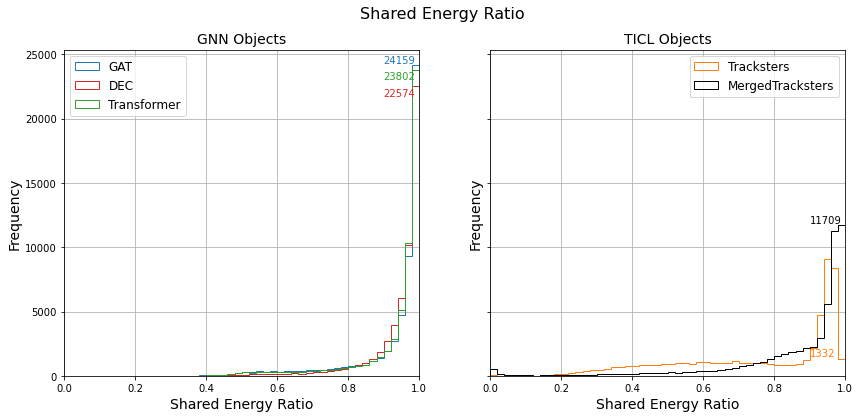

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assumption: these DataFrames are already loaded ---
# For example:
# df_GAT = pd.read_csv("csvMix/df_GAT_Mix_017.csv")
# df_DE = pd.read_csv("csvMix/df_DE_mix_0175.csv")
# df_Trans = pd.read_csv("csvMix/df_Trans_Mix_016.csv")
# df_Track = pd.read_csv("csvMix/df_TICL_track.csv")
# df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

dfs = {
    "GAT": df_GAT,
    "DEC": df_DE,
    "Transformer": df_Trans,
    "Tracksters": df_Track,
    "MergedTracksters": df_MT,
}

# Define groups for plotting.
# Left subplot ("GNN Objects"): GAT, DEC, Trans.
# Right subplot ("TICL Objects"): Tracksters, MergedTracksters.
left_group = ["GAT", "DEC", "Transformer"]
right_group = ["Tracksters", "MergedTracksters"]

# --- 1. Process Shared Energy Ratio ---
# For each dataframe, we compute for each event and cp (grouped by "event_index" and "cp_id")
# the maximum of (shared_energy / cp_raw_energy).
shared_energy_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "shared_energy", "cp_raw_energy"}
    if required_cols.issubset(df.columns):
        df_copy = df.copy()
        df_copy["energy_ratio"] = df_copy["shared_energy"] / df_copy["cp_raw_energy"]
        max_ratio = df_copy.groupby(["event_index", "cp_id"])["energy_ratio"].max()
        shared_energy_data[key] = max_ratio.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# Determine the upper bound for binning.
# If any ratio exceeds 1, use the global maximum; otherwise, use 1.
global_max = max(np.max(r) for r in shared_energy_data.values() if len(r) > 0)
upper_bound = global_max if global_max > 1 else 1

# Define fixed bins from 0 to upper_bound with 50 bins.
bins_fixed = np.linspace(0, upper_bound, 51)

# --- 2. Annotation Helper (objective frequency) ---
# This function computes the histogram (using raw counts) of the scores and identifies
# the bin containing the target_value (here, we use 1). It then annotates that bin with its count.
def annotate_hist(ax, scores, target_value, x_offset=0.0, y_offset=0.0, font_size=10, color='k'):
    counts, bins = np.histogram(scores, bins=bins_fixed, density=False)
    # Identify the appropriate bin.
    if target_value == 0:
        bin_index = 0
        x_loc = (bins[0] + bins[1]) / 2
    elif target_value >= bins_fixed[-2]:
        bin_index = -1
        x_loc = (bins[-2] + bins[-1]) / 2
    else:
        bin_index = np.searchsorted(bins, target_value) - 1
        x_loc = (bins[bin_index] + bins[bin_index+1]) / 2
    # Apply offsets.
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = str(counts[bin_index])
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

# --- 3. Define individual vertical offsets for annotations ---
# Adjust these values as needed to avoid overlapping of the text.
left_offsets = {
    "GAT": 0,
    "DEC": -1000,
    "Transformer": -900
}
right_offsets = {
    "Tracksters": 0,
    "MergedTracksters": 10
}

# --- 4. Plot Shared Energy Ratio ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Set the overall and subplot titles with a reduced gap.
plt.suptitle("Shared Energy Ratio", fontsize=16, y=0.98)
axes[0].set_title("GNN Objects", fontsize=14)
axes[1].set_title("TICL Objects", fontsize=14)

colors = {
    "GAT": "tab:blue",
    "DEC": "tab:red",
    "Transformer": "tab:green",
    "Tracksters": "tab:orange",
    "MergedTracksters": "black"
}

# Plot histograms for the left group.
for key in left_group:
    if key in shared_energy_data:
        scores = shared_energy_data[key]
        axes[0].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = left_offsets.get(key, 0)
        # Annotate the frequency in the bin covering target_value=1.
        annotate_hist(axes[0], scores, target_value=1, x_offset=-0.09, y_offset=offset,
                      font_size=10, color=colors[key])

# Plot histograms for the right group.
for key in right_group:
    if key in shared_energy_data:
        scores = shared_energy_data[key]
        axes[1].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = right_offsets.get(key, 0)
        annotate_hist(axes[1], scores, target_value=1, x_offset=-0.09, y_offset=offset,
                      font_size=10, color=colors[key])

for ax in axes:
    ax.set_xlabel("Shared Energy Ratio", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_xlim(0, upper_bound)
    ax.legend(fontsize=12)
    ax.grid(True)

plt.subplots_adjust(top=0.88)  # Reduce gap between the suptitle and subplots.
plt.show()


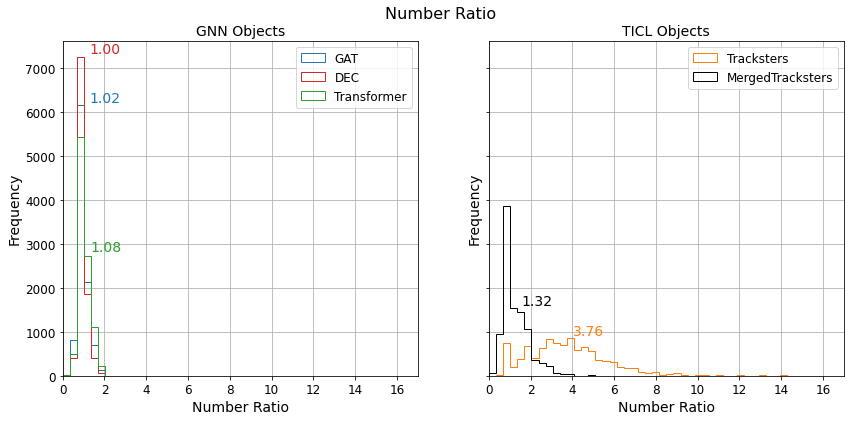

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assumption: these DataFrames are already loaded ---
# For example:
# df_GAT = pd.read_csv("csvMix/df_GAT_Mix_017.csv")
# df_DE = pd.read_csv("csvMix/df_DE_mix_0175.csv")
# df_Trans = pd.read_csv("csvMix/df_Trans_Mix_016.csv")
# df_Track = pd.read_csv("csvMix/df_TICL_track.csv")
# df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

dfs = {
    "GAT": df_GAT,
    "DEC": df_DE,
    "Transformer": df_Trans,
    "Tracksters": df_Track,
    "MergedTracksters": df_MT,
}

# Define groups for plotting.
# Left subplot ("GNN Objects"): methods GAT, DEC, Trans.
# Right subplot ("TICL Objects"): methods Tracksters, MergedTracksters.
left_group = ["GAT", "DEC", "Transformer"]
right_group = ["Tracksters", "MergedTracksters"]

# --- 1. Compute the event-wise ratio ---
# For each DataFrame, group by "event_index" and compute:
# ratio = (# unique trackster_id) / (# unique cp_id)
ratio_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "trackster_id"}
    if required_cols.issubset(df.columns):
        # Compute ratio for each event, ignoring events with 0 cp's.
        ratios = df.groupby("event_index").apply(
            lambda subdf: subdf["trackster_id"].nunique() / subdf["cp_id"].nunique()
            if subdf["cp_id"].nunique() > 0 else np.nan
        ).dropna()
        ratio_data[key] = ratios.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# Determine a global upper bound for the bins.
# If some methods have ratios > 1 then use that maximum; otherwise use 1.
global_max = max(np.max(r) for r in ratio_data.values() if len(r) > 0)
upper_bound = global_max if global_max > 1 else 1

# Define fixed bins from 0 to upper_bound (50 bins).
bins_fixed = np.linspace(0, upper_bound, 51)

# --- 2. Define an Annotation Helper to annotate the mean of the ratios ---
def annotate_mean(ax, scores, x_offset=0.0, y_offset=0.0, font_size=14, color='k'):
    mean_val = np.mean(scores)
    # Compute histogram counts to help determine vertical placement.
    counts, bins = np.histogram(scores, bins=bins_fixed, density=False)
    # Find the bin that contains the mean value.
    bin_index = np.searchsorted(bins, mean_val) - 1
    if bin_index < 0:
        bin_index = 0
    # Use the count in that bin as a baseline for vertical positioning.
    y_val = counts[bin_index]
    ax.text(mean_val + x_offset, y_val + y_offset, f"{mean_val:.2f}",
            fontsize=font_size, ha='center', va='bottom', color=color)

# --- 3. Define individual vertical offsets for the mean annotations (adjust as desired) ---
left_mean_offsets = {
    "GAT": 0,         # No vertical offset for GAT
    "DEC": 20,        # Raise DEC's annotation by 20 units
    "Transformer": 40       # Raise Transformer's annotation by 40 units
}
right_mean_offsets = {
    "Tracksters": 0,         # No vertical offset for Tracksters
    "MergedTracksters": 10   # Raise MergedTracksters' annotation by 10 units
}

# --- 4. Define colours for each method ---
colors = {
    "GAT": "tab:blue",
    "DEC": "tab:red",
    "Transformer": "tab:green",
    "Tracksters": "tab:orange",
    "MergedTracksters": "black"
}

# --- 5. Plot the histograms with mean annotations ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plt.suptitle("Number Ratio", fontsize=16, y=0.98)
axes[0].set_title("GNN Objects", fontsize=14)
axes[1].set_title("TICL Objects", fontsize=14)

# Plot left group.
for key in left_group:
    if key in ratio_data:
        scores = ratio_data[key]
        axes[0].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = left_mean_offsets.get(key, 0)
        annotate_mean(axes[0], scores, x_offset=1, y_offset=offset, font_size=14, color=colors[key])

# Plot right group.
for key in right_group:
    if key in ratio_data:
        scores = ratio_data[key]
        axes[1].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = right_mean_offsets.get(key, 0)
        annotate_mean(axes[1], scores, x_offset=1, y_offset=offset, font_size=14, color=colors[key])

for ax in axes:
    ax.set_xlabel("Number Ratio", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(0, upper_bound)
    ax.legend(fontsize=12)
    ax.grid(True)

plt.subplots_adjust(top=0.9)  # Reduce gap between suptitle and subplots.
plt.show()
